# 2D decaying turbulence

A simulations of decaying two-dimensional turbulence.

In [1]:
using FourierFlows, PyPlot, Printf, Random

using Random: seed!
using FFTW: rfft, irfft

import GeophysicalFlows.TwoDNavierStokes
import GeophysicalFlows.TwoDNavierStokes: energy, enstrophy
import GeophysicalFlows: peakedisotropicspectrum

## Choosing a device: CPU or GPU

In [2]:
dev = CPU()     # Device (CPU/GPU)
nothing # hide

## Numerical, domain, and simulation parameters

First, we pick some numerical and physical parameters for our model.

In [3]:
n, L  = 128, 2π             # grid resolution and domain length
nothing # hide

# Then we pick the time-stepper parameters
    dt = 1e-2  # timestep
nsteps = 4000  # total number of steps
 nsubs = 1000  # number of steps between each plot
nothing # hide

## Problem setup
We initialize a `Problem` by providing a set of keyword arguments. The
`stepper` keyword defines the time-stepper to be used.

In [4]:
prob = TwoDNavierStokes.Problem(; nx=n, Lx=L, ny=n, Ly=L, dt=dt, stepper="FilteredRK4", dev=dev)
nothing # hide

Next we define some shortcuts for convenience.

In [5]:
sol, cl, vs, gr, filter = prob.sol, prob.clock, prob.vars, prob.grid, prob.timestepper.filter
x, y = gridpoints(gr)
nothing # hide

## Setting initial conditions

Our initial condition closely tries to reproduce the initial condition used
in the paper by McWilliams (_JFM_, 1984)

In [6]:
seed!(1234)
k0, E0 = 6, 0.5
zetai  = peakedisotropicspectrum(gr, k0, E0, mask=filter)
TwoDNavierStokes.set_zeta!(prob, zetai)
nothing # hide

Let's plot the initial vorticity field:

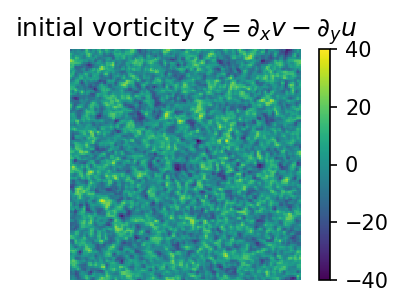

In [7]:
fig = figure(figsize=(3, 2), dpi=150)
pcolormesh(x, y, vs.zeta)
axis("square")
xticks(-2:2:2)
yticks(-2:2:2)
title(L"initial vorticity $\zeta = \partial_x v - \partial_y u$")
colorbar()
clim(-40, 40)
axis("off")
gcf() # hide

## Diagnostics

Create Diagnostics -- `energy` and `enstrophy` functions are imported at the top.

In [8]:
E = Diagnostic(energy, prob; nsteps=nsteps)
Z = Diagnostic(enstrophy, prob; nsteps=nsteps)
diags = [E, Z] # A list of Diagnostics types passed to "stepforward!" will  be updated every timestep.
nothing # hide

## Output

We choose folder for outputing `.jld2` files and snapshots (`.png` files).

In [9]:
filepath = "."
plotpath = "./plots_decayingTwoDNavierStokes"
plotname = "snapshots"
filename = joinpath(filepath, "decayingTwoDNavierStokes.jld2")
nothing # hide

Do some basic file management

In [10]:
if isfile(filename); rm(filename); end
if !isdir(plotpath); mkdir(plotpath); end
nothing # hide

And then create Output

In [11]:
get_sol(prob) = Array(prob.sol) # extracts the Fourier-transformed solution
get_u(prob) = Array(irfft(im*gr.l.*gr.invKrsq.*sol, gr.nx))
out = Output(prob, filename, (:sol, get_sol), (:u, get_u))
saveproblem(out)
nothing # hide

## Visualizing the simulation

We define a function that plots the vorticity field and the evolution of
energy and enstrophy diagnostics.

In [12]:
function plot_output(prob, fig, axs; drawcolorbar=false)
  TwoDNavierStokes.updatevars!(prob)
  sca(axs[1])
  pcolormesh(x, y, vs.zeta)
  title("Vorticity")
  clim(-40, 40)
  axis("off")
  axis("square")
  if drawcolorbar==true
    colorbar()
  end

  sca(axs[2])
  cla()
  plot(E.t[1:E.i], E.data[1:E.i]/E.data[1], label="energy \$E(t)/E(0)\$")
  plot(Z.t[1:Z.i], Z.data[1:E.i]/Z.data[1], label="enstrophy \$Z(t)/Z(0)\$")
  xlabel(L"t")
  ylabel(L"\Delta E, \, \Delta Z")
end
nothing # hide

## Time-stepping the `Problem` forward

We time-step the `Problem` forward in time.

In [13]:
startwalltime = time()
while cl.step < nsteps
  stepforward!(prob, diags, nsubs)
  saveoutput(out)

  log = @sprintf("step: %04d, t: %d, ΔE: %.4f, ΔZ: %.4f, walltime: %.2f min",
    cl.step, cl.t, E.data[E.i]/E.data[1], Z.data[Z.i]/Z.data[1], (time()-startwalltime)/60)

  println(log)
end
println("finished")

step: 1000, t: 10, ΔE: 0.9676, ΔZ: 0.1663, walltime: 0.11 min
step: 2000, t: 20, ΔE: 0.9658, ΔZ: 0.1214, walltime: 0.15 min
step: 3000, t: 30, ΔE: 0.9651, ΔZ: 0.1025, walltime: 0.19 min
step: 4000, t: 40, ΔE: 0.9640, ΔZ: 0.0760, walltime: 0.23 min
finished


## Plot
Now let's see what we got. We plot the output,

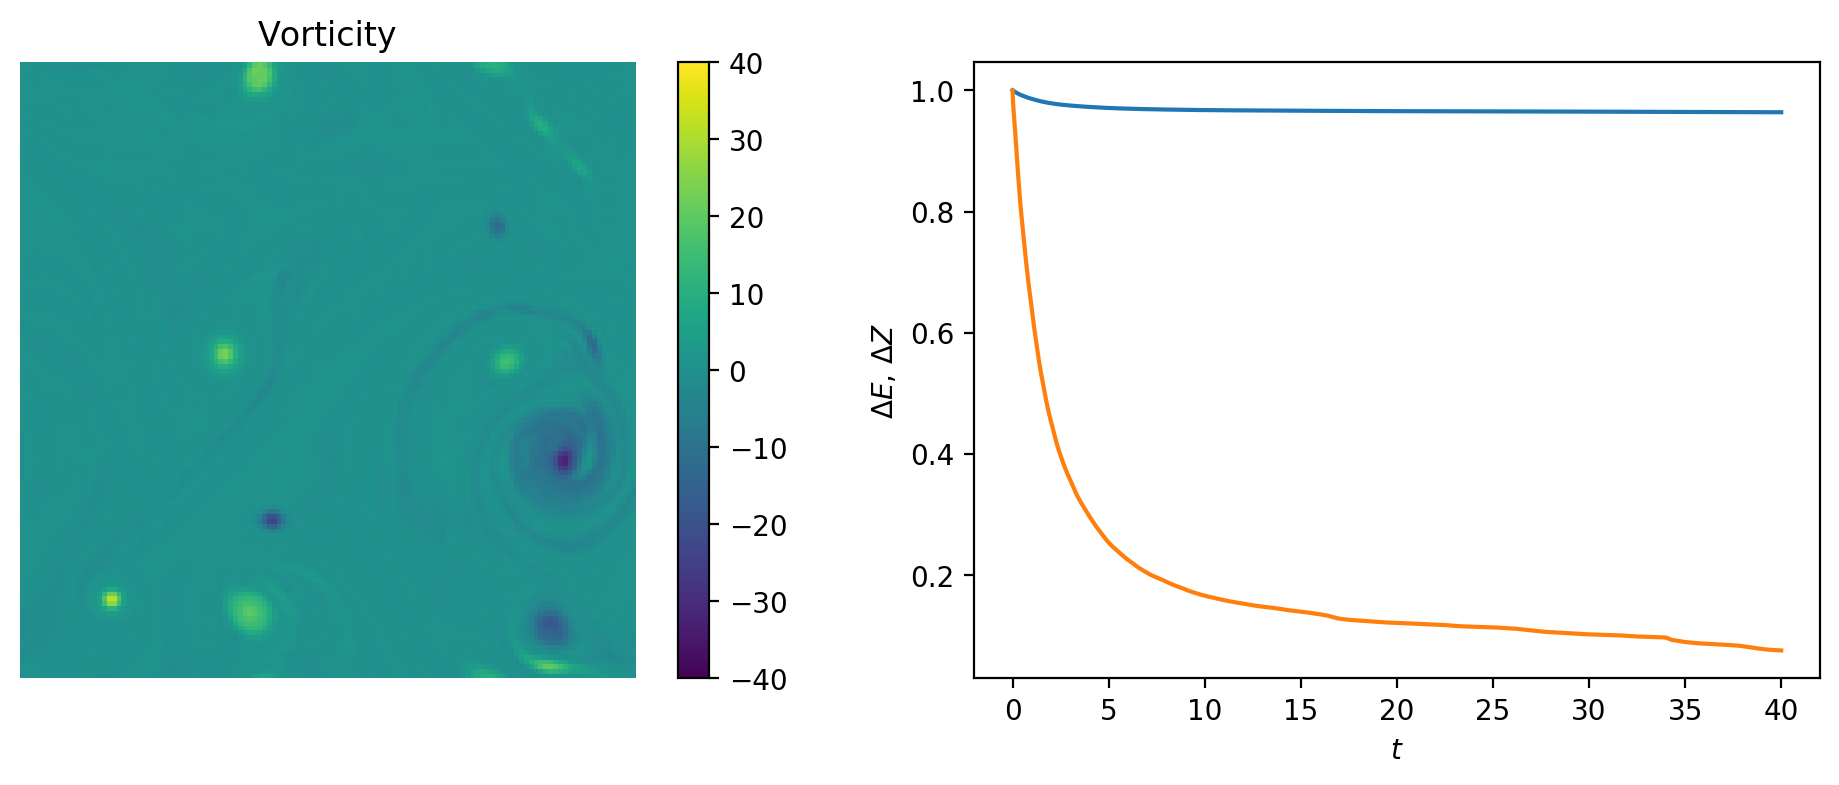

In [14]:
fig, axs = subplots(ncols=2, nrows=1, figsize=(12, 4), dpi=200)
plot_output(prob, fig, axs; drawcolorbar=true)
gcf() # hide

and finally save the figure

In [15]:
savename = @sprintf("%s_%09d.png", joinpath(plotpath, plotname), cl.step)
savefig(savename, dpi=240)

## Radial energy spectrum

After the simulation is done we plot the radial energy spectrum to illustrate
how `FourierFlows.radialspectrum` can be used,

In [16]:
E  = @. 0.5*(vs.u^2 + vs.v^2) # energy density
Eh = rfft(E)                  # Fourier transform of energy density
kr, Ehr = FourierFlows.radialspectrum(Eh, gr, refinement=1) # compute radial specturm of `Eh`
nothing # hide

and we plot it.

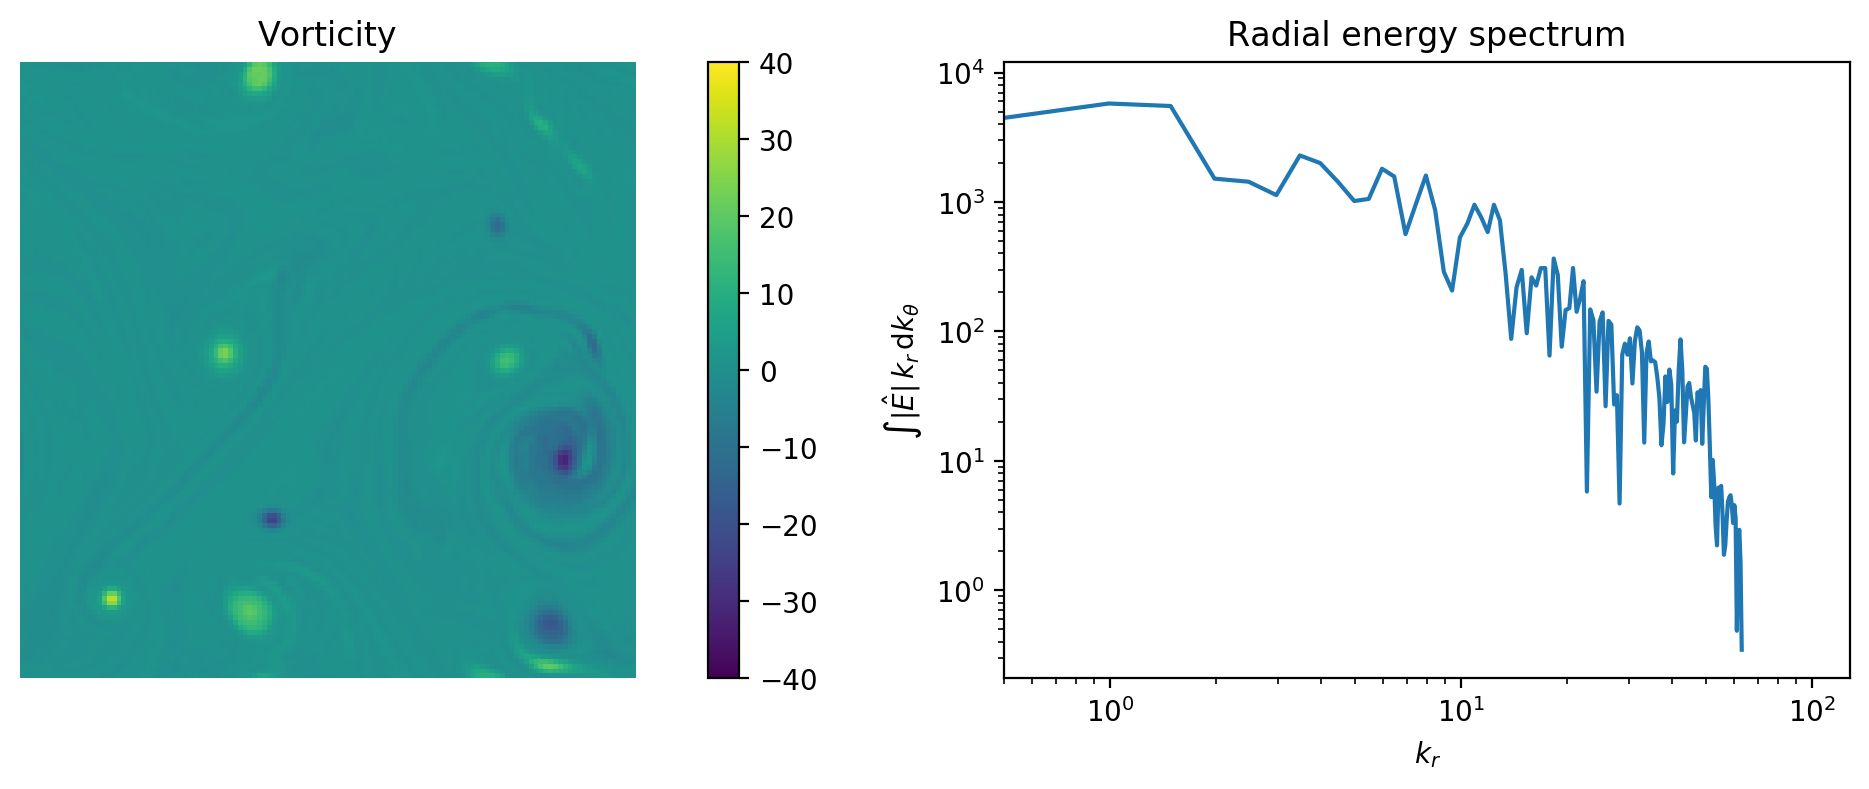

In [17]:
fig2, axs = subplots(ncols=2, figsize=(12, 4), dpi=200)

sca(axs[1])
pcolormesh(x, y, vs.zeta)
xlabel(L"x")
ylabel(L"y")
title("Vorticity")
colorbar()
clim(-40, 40)
axis("off")
axis("square")

sca(axs[2])
plot(kr, abs.(Ehr))
xlabel(L"k_r")
ylabel(L"\int | \hat{E} | \, k_r \,\mathrm{d} k_{\theta}")
title("Radial energy spectrum")

axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlim(5e-1, gr.nx)
gcf() # hide

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*